In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
import os
os.chdir('/Users/Lenovo/Desktop/EBAC')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('TempNY.csv')
df = df.drop('Unnamed: 2', axis = 1)
df.index = df["Year"]
df = df.drop("Year", axis = 1)

# División en entrenamiento (90%) y prueba (10%)
n = len(df)
train_size = int(n * 0.9)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [5]:
from statsmodels.tsa.stattools import adfuller

# Prueba Dickey-Fuller
result = adfuller(train["Average"])
print("p-valor Dickey-Fuller:", result[1])

p-valor Dickey-Fuller: 0.4220120619118103


In [7]:
# Aplicamos diferencia
train_diff = train["Average"].diff().dropna()

result2 = adfuller(train_diff)
print("p-valor Dickey-Fuller (con 1 diferencia):", result2[1])

p-valor Dickey-Fuller (con 1 diferencia): 1.5713108896119484e-13


In [9]:
from statsmodels.tsa.arima.model import ARIMA

models = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), (3,1,1), (1,1,0)]
for order in models:
    model = ARIMA(train["Average"], order=order)
    result = model.fit()
    print(f"Modelo ARIMA{order} - AIC: {result.aic}")

Modelo ARIMA(1, 1, 1) - AIC: 435.2301153581751
Modelo ARIMA(2, 1, 1) - AIC: 436.82414714470053
Modelo ARIMA(1, 1, 2) - AIC: 437.02587578417206
Modelo ARIMA(2, 1, 2) - AIC: 436.8133808416668
Modelo ARIMA(3, 1, 1) - AIC: 438.8183499812859
Modelo ARIMA(1, 1, 0) - AIC: 462.29533013880337


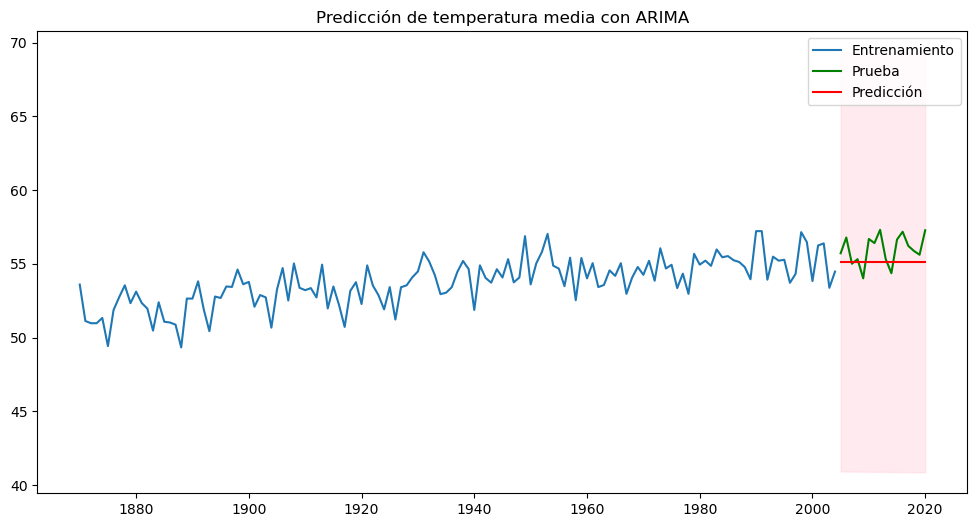

In [11]:
# ARIMA(1,1,1) menor AIC
best_model = ARIMA(train["Average"], order=(2,1,2))
best_result = best_model.fit()

# Predicción para el rango de prueba
start = test.index[0]
end = test.index[-1]

pred = best_result.get_prediction(start=start, end=end)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

# Graficamos
plt.figure(figsize=(12,6))
plt.plot(train["Average"], label="Entrenamiento")
plt.plot(test["Average"], label="Prueba", color='green')
plt.plot(pred_mean, label="Predicción", color='red')
plt.fill_between(pred_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("Predicción de temperatura media con ARIMA")
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test["Average"], pred_mean)
rmse = np.sqrt(mean_squared_error(test["Average"], pred_mean))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1.118066688659142
RMSE: 1.311074992928359


In [17]:
# Pronóstico puntual para los próximos 5 años
future_forecast = best_result.forecast(steps=5)
print("Pronóstico puntual para los próximos 5 años:")
print(future_forecast)

# Intervalos de confianza al 95%
future_conf_int = best_result.get_forecast(steps=5).conf_int(alpha=0.05)
print("\nIntervalo de confianza (95%) para el pronóstico:")
print(future_conf_int)

Pronóstico puntual para los próximos 5 años:
135    55.131765
136    55.020941
137    55.189496
138    55.031565
139    55.186776
Name: predicted_mean, dtype: float64

Intervalo de confianza (95%) para el pronóstico:
     lower Average  upper Average
135      52.812699      57.450831
136      52.651033      57.390849
137      52.785444      57.593547
138      52.612170      57.450961
139      52.738291      57.635261


In [21]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcular el MAPE entre valores reales y predicciones
mape = mean_absolute_percentage_error(test["Average"], pred_mean)
print(f"MAPE: {round(mape * 100, 2)}%")

MAPE: 1.98%


# Conclusion:
Al tener un mape del 1.98% y los intervalos de confianza del 95% estan muy estrechos, podemos concluir que los valores puntuales que estamos prediciendo tienen alto grado de confiabilidad